# Example usage of the Yin-Yang dataset

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataset import YinYangDataset
from torch.utils.data import DataLoader

%matplotlib inline

### Setup datasets (training, validation and test set)

In [2]:
dataset_train = YinYangDataset(size=5000, seed=42)
dataset_validation = YinYangDataset(size=1000, seed=41)
dataset_test = YinYangDataset(size=1000, seed=40)

### Setup PyTorch dataloaders

In [3]:
batchsize_train = 20
batchsize_eval = len(dataset_test)

train_loader = DataLoader(dataset_train, batch_size=batchsize_train, shuffle=True)
val_loader = DataLoader(dataset_validation, batch_size=batchsize_eval, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batchsize_eval, shuffle=False)

### Plot data

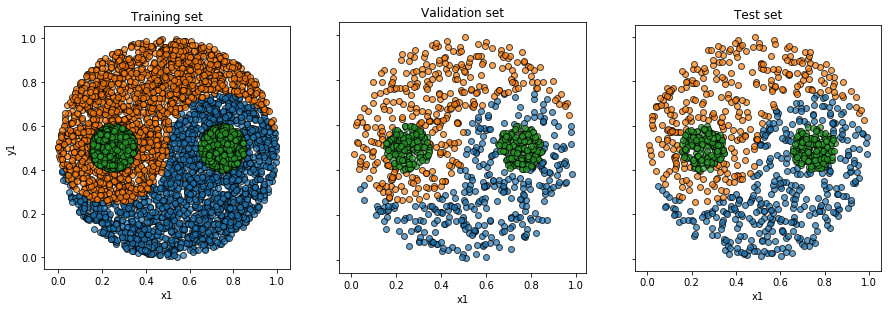

In [4]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(15, 8))
titles = ['Training set', 'Validation set', 'Test set']
for i, loader in enumerate([train_loader, val_loader, test_loader]):
    axes[i].set_title(titles[i])
    axes[i].set_aspect('equal', adjustable='box')
    xs = []
    ys = []
    cs = []
    for batch, batch_labels in loader:
        for j, item in enumerate(batch):
            x1, y1, x2, y2 = item
            c = batch_labels[j]
            xs.append(x1)
            ys.append(y1)
            cs.append(c)
    xs = np.array(xs)
    ys = np.array(ys)
    cs = np.array(cs)
    axes[i].scatter(xs[cs == 0], ys[cs == 0], color='C0', edgecolor='k', alpha=0.7)
    axes[i].scatter(xs[cs == 1], ys[cs == 1], color='C1', edgecolor='k', alpha=0.7)
    axes[i].scatter(xs[cs == 2], ys[cs == 2], color='C2', edgecolor='k', alpha=0.7)
    axes[i].set_xlabel('x1')
    if i == 0:
        axes[i].set_ylabel('y1')

### Setup ANN

In [5]:
class Net(torch.nn.Module):
    def __init__(self, network_layout):
        super(Net, self).__init__()
        self.n_inputs = network_layout['n_inputs']
        self.n_layers = network_layout['n_layers']
        self.layer_sizes = network_layout['layer_sizes']
        self.layers = torch.nn.ModuleList()
        layer = torch.nn.Linear(self.n_inputs, self.layer_sizes[0], bias=True)
        self.layers.append(layer)
        for i in range(self.n_layers-1):
            layer = torch.nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1], bias=True)
            self.layers.append(layer)
        return

    def forward(self, x):
        x_hidden = []
        for i in range(self.n_layers):
            x = self.layers[i](x)
            if not i == (self.n_layers-1):
                relu = torch.nn.ReLU()
                x = relu(x)
                x_hidden.append(x)
        return x

In [6]:
torch.manual_seed(12345)
# ANN with one hidden layer (with 120 neurons)
network_layout = {
    'n_inputs': 4,
    'n_layers': 2,
    'layer_sizes': [30, 3],
}
net = Net(network_layout)

# Linear classifier for reference
shallow_network_layout = {
    'n_inputs': 4,
    'n_layers': 1,
    'layer_sizes': [3],
}
linear_classifier = Net(shallow_network_layout)

### Train ANN

In [7]:
# used to determine validation accuracy after each epoch in training
def validation_step(net, criterion, loader):
    with torch.no_grad():
        num_correct = 0
        num_shown = 0
        for j, data in enumerate(loader):
            inputs, labels = data
            # need to convert to float32 because data is in float64
            inputs = inputs.float()
            outputs = net(inputs)
            winner = outputs.argmax(1)
            num_correct += len(outputs[winner == labels])
            num_shown += len(labels)
        accuracy = float(num_correct) / num_shown
    return accuracy

# set training parameters
n_epochs = 300
learning_rate = 0.01
val_accuracies = []
train_accuracies = []
# setup loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# train for n_epochs
for epoch in range(n_epochs):
    val_acc = validation_step(net, criterion, val_loader)
    if epoch % 25 == 0:
        print('Validation accuracy after {0} epochs: {1}'.format(epoch, val_acc))
    val_accuracies.append(val_acc)
    num_correct = 0
    num_shown = 0
    for j, data in enumerate(train_loader):
        inputs, labels = data
        # need to convert to float32 because data is in float64
        inputs = inputs.float()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = net(inputs)
        winner = outputs.argmax(1)
        num_correct += len(outputs[winner == labels])
        num_shown += len(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    accuracy = float(num_correct) / num_shown
    train_accuracies.append(accuracy)

# after training evaluate on test set
test_acc = validation_step(net, criterion, test_loader)
print('#############################')
print('Final test accuracy:', test_acc)
print('#############################')

Validation accuracy after 0 epochs: 0.336
Validation accuracy after 25 epochs: 0.846
Validation accuracy after 50 epochs: 0.886
Validation accuracy after 75 epochs: 0.922
Validation accuracy after 100 epochs: 0.976
Validation accuracy after 125 epochs: 0.975
Validation accuracy after 150 epochs: 0.966
Validation accuracy after 175 epochs: 0.97
Validation accuracy after 200 epochs: 0.981
Validation accuracy after 225 epochs: 0.977
Validation accuracy after 250 epochs: 0.907
Validation accuracy after 275 epochs: 0.965
#############################
('Final test accuracy:', 0.977)
#############################


### Plot training results

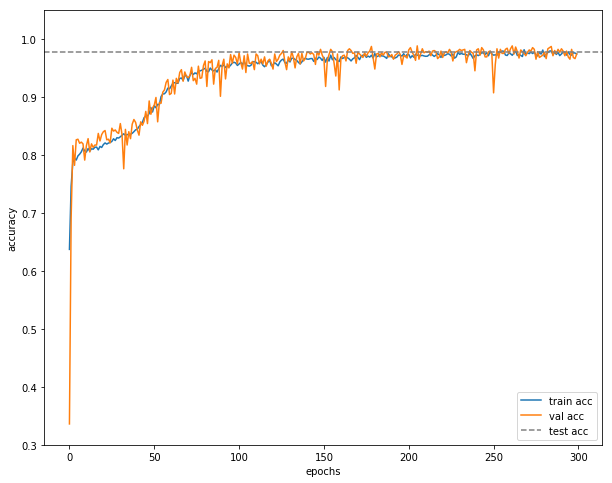

In [8]:
plt.figure(figsize=(10,8))
plt.plot(train_accuracies, label='train acc')
plt.plot(val_accuracies, label='val acc')
plt.axhline(test_acc, ls='--', color='grey', label='test acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0.3, 1.05)
plt.legend()

### Train Linear classifier as reference

In [9]:
val_accuracies = []
train_accuracies = []
# setup loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(linear_classifier.parameters(), lr=learning_rate)

# train for n_epochs
for epoch in range(n_epochs):
    val_acc = validation_step(linear_classifier, criterion, val_loader)
    if epoch % 25 == 0:
        print('Validation accuracy of linear classifier after {0} epochs: {1}'.format(epoch, val_acc))
    val_accuracies.append(val_acc)
    num_correct = 0
    num_shown = 0
    for j, data in enumerate(train_loader):
        inputs, labels = data
        # need to convert to float32 because data is in float64
        inputs = inputs.float()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        outputs = linear_classifier(inputs)
        winner = outputs.argmax(1)
        num_correct += len(outputs[winner == labels])
        num_shown += len(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    accuracy = float(num_correct) / num_shown
    train_accuracies.append(accuracy)

# after training evaluate on test set
test_acc = validation_step(linear_classifier, criterion, test_loader)
print('#############################')
print('Final test accuracy linear classifier:', test_acc)
print('#############################')

Validation accuracy of linear classifier after 0 epochs: 0.306
Validation accuracy of linear classifier after 25 epochs: 0.65
Validation accuracy of linear classifier after 50 epochs: 0.652
Validation accuracy of linear classifier after 75 epochs: 0.643
Validation accuracy of linear classifier after 100 epochs: 0.626
Validation accuracy of linear classifier after 125 epochs: 0.637
Validation accuracy of linear classifier after 150 epochs: 0.641
Validation accuracy of linear classifier after 175 epochs: 0.646
Validation accuracy of linear classifier after 200 epochs: 0.654
Validation accuracy of linear classifier after 225 epochs: 0.649
Validation accuracy of linear classifier after 250 epochs: 0.651
Validation accuracy of linear classifier after 275 epochs: 0.631
#############################
('Final test accuracy linear classifier:', 0.643)
#############################


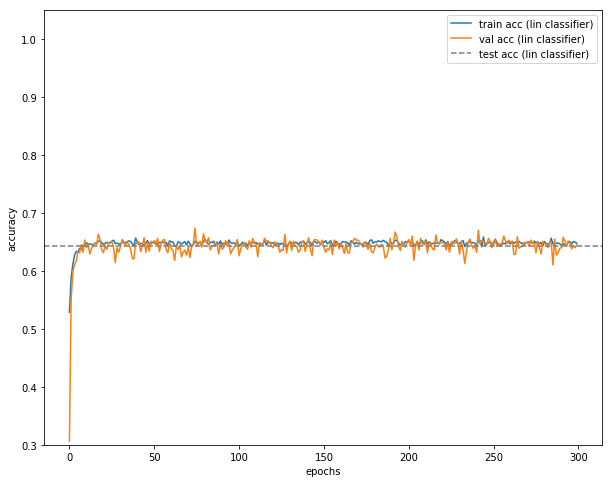

In [10]:
plt.figure(figsize=(10,8))
plt.plot(train_accuracies, label='train acc (lin classifier)')
plt.plot(val_accuracies, label='val acc (lin classifier)')
plt.axhline(test_acc, ls='--', color='grey', label='test acc (lin classifier)')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0.3, 1.05)
plt.legend()